<class 'numpy.ndarray'> (540, 960, 3)


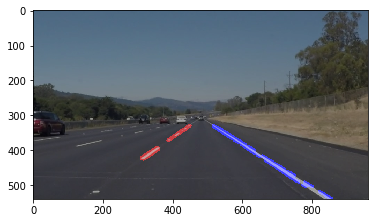

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image):
    # Gray scale conversion, gaussian filter
    image_gray = grayscale(image)
    # Gaussian filtering
    image_filtered = gaussian_blur(image_gray,5)
    
    # Apply Canny filtering
    image_canny = canny(image_gray, 100,200) 
    imshape = image_canny.shape
    
    # Apply mask to select zone of interest
    y_min = 330 # horizontal cut of the zone of interest - will be used in the last part to delimitate the drawn line
    verticles = np.array([[(90,imshape[0]),(400, y_min), (imshape[1]-400, y_min), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    image_interest = region_of_interest(image_canny,verticles)
    
    # Apply Hough Transform
    #Parameters:
    rho = 1
    theta = 1
    threshold = 14
    min_line_len = 5
    max_line_gap =15

    image_hough = hough_lines(image_interest, rho, theta, threshold, min_line_len, max_line_gap)
    lines = cv2.HoughLinesP(image_interest, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #print(type(lines),lines.shape,lines.dtype)
    #Split left and right lines
    left=[]
    right=[]
    slope_left_sum = 0   # sum of all the slopes values for the left lanes to compute the average left slope
    slope_right_sum = 0  # same for right
    offset_left_sum = 0  # sum of all the offset (b) values for the left lanes to compute the average left line offset
    offset_right_sum = 0 # same for right
    #print(lines)

    for i in range(0,lines.shape[0]):
        #if x1=x2 then the line is vertical and can be ignored
        #if y1=y2 then the line is horizontal and can be ignored
        if((lines[i][0][2]!=lines[i][0][0]) & (lines[i][0][1]!=lines[i][0][3])): 

            slope = float((lines[i][0][3]-lines[i][0][1]))/float((lines[i][0][2]-lines[i][0][0]))

            if (slope > 0): #right lane
                right.append(lines[i][:][:])
                slope_right_sum = slope_right_sum + slope
                offset_right_sum = offset_right_sum + (lines[i][0][1] - slope*lines[i][0][0])  # b = y1-ax1

            else:
                left.append(lines[i][:][:])
                slope_left_sum = slope_left_sum + slope
                offset_left_sum = offset_left_sum + (lines[i][0][1] - slope*lines[i][0][0])  # b = y1-ax1

    #https://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
    #print(lines_left)
    #print(len(lines_left))

    lines_left=np.array(left)
    lines_right=np.array(right)

    #print('detected left lines  ',type(lines_left),lines_left.shape)
    #print('detected right lines  ',type(lines_right),lines_right.shape)
    
    line_image_right = np.copy(image)*0 #creating a blank to draw lines on
    line_image_left = np.copy(image)*0 #creating a blank to draw lines on
    
    #Draw left lines
    for line in lines_left:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image_left,(x1,y1),(x2,y2),(255,0,0),10)
    #Draw right lines
    for line in lines_right:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image_right,(x1,y1),(x2,y2),(0,0,255),10)
    
    image_2 = np.copy(image) #copy orginal image to combine with detected lanes

    #combine lines to original image
    combo_2 = cv2.addWeighted(image_2, 0.8, line_image_left, 1, 0) 
    combo_2 = cv2.addWeighted(combo_2, 0.8, line_image_right, 1, 0)
    return combo_2


#Test function on 1 image
image_input = mpimg.imread('test_images/solidWhiteRight.jpg')
image_result = process_image(image_input)
print(type(image_result),image_result.shape)
plt.imshow(image_result)



In [ ]:
white_output = 'test_videos_outputs/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
print(type(clip1))
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<class 'moviepy.video.io.VideoFileClip.VideoFileClip'>
[MoviePy] >>>> Building video test_videos_outputs/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_outputs/solidWhiteRight.mp4


 57%|████████████████████████████████████████████████████████████████████████▌                                                      | 72/126 [00:08<00:05,  9.50it/s]